# Image Denoising Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a denoising model. For a given noisy image $X$, our model should learn to predict the denoised image $y$.


**Objectives**
- Visualize images
- Preprocess images for the neural network
- Fit a custom CNN for the task

## 1. Load Data

👉 Let's download the dataset archive.
It contains RGB and Black & White images we will be using for the rest of this challenge.

In [1]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  33.3M      0  0:00:02  0:00:02 --:--:-- 33.3M
total 80
-rw-rw-r-- 1 primitive primitive 20937 Jun 30 09:09 image_denoising.ipynb
drwx------ 2 primitive primitive 53248 Jun  9 15:06 paintings
-rw-rw-r-- 1 primitive primitive     0 Jun 29 09:24 README.md
drwxrwxr-x 2 primitive primitive  4096 Jun 29 09:24 tests


In [ ]:
import glob

dataset_paths = glob.glob("./paintings/*.jpg")
dataset_paths

❓ **Display the image at index `53` of this dataset_paths (i.e the 54-th image)**

<details>
    <summary>Hint</summary>
    Use the <code>PIL.Image.open</code> and <code>matplotlib.pyplot.imshow</code> functions.
</details>

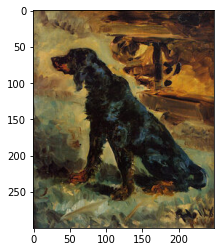

In [5]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(dataset_paths[53])

plt.imshow(img)


❓ **What is the shape of the image you displayed above `img_shape`?  How many dimensions `img_dim` does it have ?**

In [8]:
# YOUR CODE HERE
import numpy as np

np.array(img).shape

(300, 249, 3)

❓ **What was in the image above?**

In [9]:
img_shape = (300, 249, 3)
img_dim = 3

# Uncomment the correct answer

#is_portrait = True
is_portrait = False

is_colored_image = True
#is_colored_image = False

In [10]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing

❓ **Store all images from the dataset folder in a list of numpy arrays called `dataset_images`**

- It can take a while
- If the dataset is too big to fit in memory, just take the first half (or quarter) of all pictures

In [13]:
# YOUR CODE HERE
dataset_images = []
for i in range(0, len(dataset_paths)):
    dataset_images.append(mpimg.imread(dataset_paths[i]))

### 2.1 Reshape, Resize, Rescale

Let's simplify our dataset and convert it to a single numpy array

❓ **First, check if that all the images in the dataset have the same number of dimensions**.
- What do you notice?
- How do you explain it? 

In [ ]:
# YOUR CODE HERE
for img in dataset_images:
    print(np.array(img).shape)
    
#
# Not all images have a 3rd dimention which is typically the RGB colour values
# Also all images have different widths and heights
#

👉 We convert for you all black & white images into 3-colored ones by duplicating the image on three channels, so as to have only 3D arrays

In [19]:
from tqdm import tqdm

dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in tqdm(dataset_images)]
set([x.ndim for x in dataset_images])

100%|██████████| 1085/1085 [00:01<00:00, 677.17it/s]


{3}

❓ **What about their shape now ?**
- Do they all have the same width/heights ? If not:
- Resize the images (120 pixels height and 100 pixels width) in the dataset, using `tensorflow.image.resize` function.
- Now that they all have the same shape, store them as a numpy array `dataset_resized`.
- This array should thus be of size $(n_{images}, 120, 100, 3)$

In [24]:
# YOUR CODE HERE
#
# All images have a 3rd dimension now
#
import tensorflow as tf
dataset_resized = []
for img in dataset_images:
    dataset_resized.append(tf.image.resize(img, (120,100)))

❓ **Rescale the data of each image between $0$ and $1$**
- Save your resulting list as `dataset_scaled`

In [563]:
# YOUR CODE HERE

### 2.2 Create (X,y) sets

👉 Now, we'll add for you some **random noise** to our images to simulate noise (that our model will try to remove later)

In [566]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

❓ **Plot a noisy image below to visualize the noise and compare it with the normal one**

In [571]:
# YOUR CODE HERE

❓ **Create your `(X_train, Y_train)`, `(X_test, Y_test)` training set for your problem**

- Remember you are trying to use "noisy" pictures in order to predict the "normal" ones.
- Keeping about `20%` of randomly sampled data as test set

In [572]:
# YOUR CODE HERE

In [573]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

### 3.1 Architecture

👉 Run the cell below that defines the decoder

In [575]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential

In [576]:
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

❓ **Now, build the `encoder` that plugs correctly with the decoder defined above**. Make sure that:
- The output of your `encoder` is the same shape as the input of the `decoder`
- Use a convolutional neural network architecture without transfer learning
- Keep it simple
- Print model summary

In [577]:
# CODE HERE YOUR ENCODER ARCHITECTURE AND PRINT IT'S MODEL SUMMARY

encoder = None

👉 **Test your encoder below**

In [579]:
# HERE WE BUILD THE AUTO-ENCODER (ENCODER + DECODER) FOR YOU. IT SHOULD PRINT A NICE SUMMARY
from tensorflow.keras.models import Model

x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

### 3.2 Training

❓ **Before training the autoencoder, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "stupid" case where you don't manage to de-noise anything at all.
- Store the result under `score_baseline`

In [580]:
# YOUR CODE HERE

❓ Now, **train your autoencoder**

- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 5 minutes of training without GPUs.

In [581]:
# YOUR CODE HERE

❓ **Plot your training and validation loss at each epoch using the cell below**

In [583]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Evaluate your performances on test set**
- Compute your de-noised test set `Y_pred` 
- Store your test score as `score_test`
- Plot a de-noised image from your test set and compare it with the original and noisy one using the cell below

In [585]:
# YOUR CODE HERE

In [591]:
# RUN THIS CELL TO CHECK YOUR RESULTS
idx = 0

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

🧪 **Send your results below**

In [588]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()